In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

введём следующие базовые параметры:

In [2]:
# сколько денег в среднем приносит один пользователь в месяц, условных единиц
user_profit = 10
# сколько денег в среднем вкладывается в удержание одного пользователя в месяц
hold_cost = 2
# с какой вероятностью пользователь, собиравшийся уйти примет предложение
accept_prob = 0.5
# сколько пользователей будет участвовать в кампании
part_prop = []

Загрузим показавшее лучший результат на kaggle предсказание. В столбце result вероятность принадлежности к группе "отток"

In [3]:
pred = pd.read_csv('final.csv').sort_values('result', ascending=False).result

Сразу усложним модель, добавив еще параметры:

In [4]:
# продолжительность скидки для пользователя, месяцы
action_duration = 3
# вероятность, что пользователь останется клиентом 
# после окончания акции и до конца прогнозного периода
hold_prob = 0.5
# длина прогнозного периода, месяцы
total_duration = 12

Напишем функцию, принимающую все эти параметры и возвращающую доход

In [5]:
def model(pred, user_profit=10, hold_cost=2, accept_prob=0.5, part_prop=1, 
          action_duration=3, hold_prob=0.5, total_duration=12):
    if part_prop == 0 :
        return 0
    n_users = int(part_prop * pred.shape[0])
    no_action_income = ((1 - pred[:n_users]) * user_profit * total_duration).sum()
    # будем считать, что пользователь, который не собирался уходить всегда примет акцию
    # посчитаем сколько мы потеряем на таких пользователях
    no_churn_users_lose = action_duration * hold_cost *  n_users * (1 - pred[:n_users].mean())
    # посчитаем доход от тех пользователей, которые собирались уйти, но останутся из-за акции
    churn_users_income = pred[:n_users].mean() * n_users * accept_prob * (
        (user_profit-hold_cost) * action_duration + hold_prob * user_profit * (
        total_duration - action_duration))
    action_income = churn_users_income - no_churn_users_lose

    return action_income

Построим график зависимости дохода от доли пользователей, участвующих в акции, остальные параметры оставим стандратными.

In [15]:
part_prop = np.linspace(0, 1, 1000)

In [16]:
incomes = []
for p_p in part_prop:
    incomes.append(model(pred, part_prop=p_p))

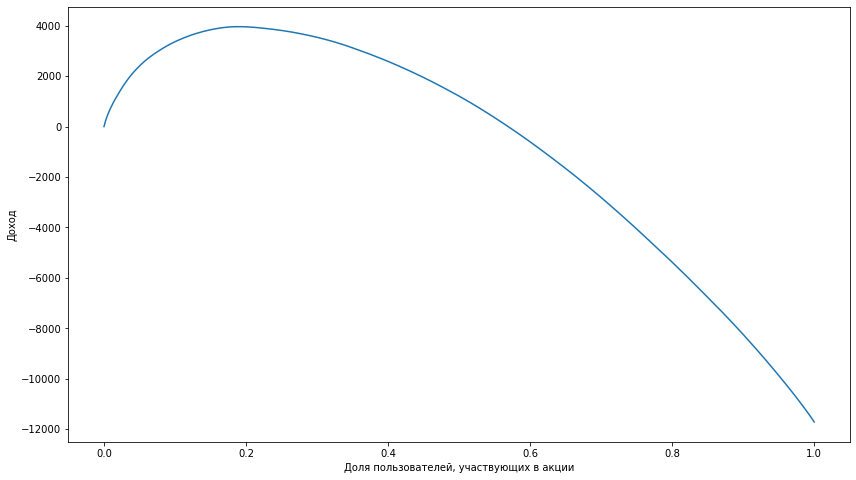

In [17]:
plt.figure(figsize=(14,8))
plt.xlabel('Доля пользователей, участвующих в акции')
plt.ylabel('Доход')
plt.plot(part_prop, incomes)
plt.show()

Как видим, наша акция приносит доход только когда маленькая часть пользователей участвует в акции.

Ограничим верхний предел доли 0.25

In [10]:
part_prop = np.linspace(0, 0.25, 100)

In [11]:
incomes = []
for p_p in part_prop:
    incomes.append(model(pred, part_prop=p_p))

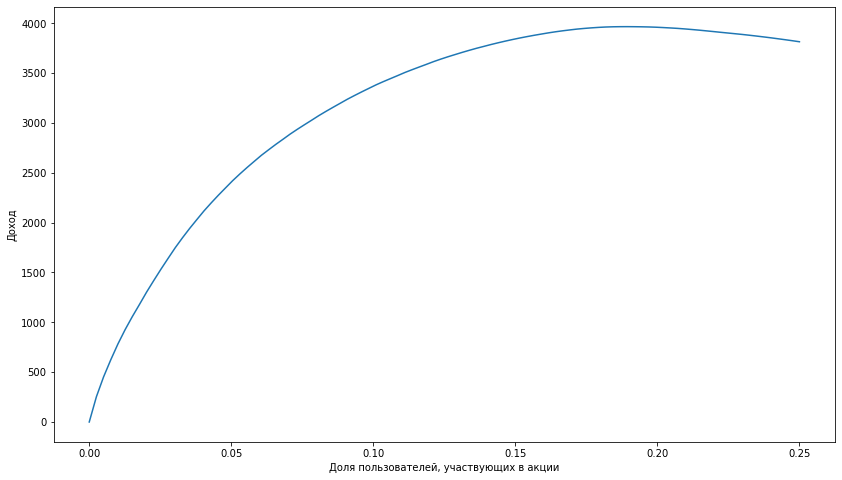

In [13]:
plt.figure(figsize=(14,8))
plt.xlabel('Доля пользователей, участвующих в акции')
plt.ylabel('Доход')
plt.plot(part_prop, incomes)
plt.show()

In [18]:
print(f'Максимальный доход достигается при доле пользователей = {part_prop[np.argmax(incomes)]:.3f}')
print(f'Максимальный доход = {np.amax(incomes):.1f}')

Максимальный доход достигается при доле пользователей = 0.189
Максимальный доход = 3965.3


Наша модель дает вероятность оттока выше 50% только для 3 пользователей из 10000 тысячи, при таком раскладе, очевидно, что она будет эффективной только при достаточно низкой стоимости удержания, т.к. в другом случае затраты, которые мы понесем на акцию для пользователей, которые так и так не собирались нас покидать сильно превысят доходы от удержания очень маленького количества человек.

Проверим это, для начала изменив цену удержания

In [19]:
hold_cost = 3

In [20]:
part_prop = np.linspace(0, 0.1, 100)
incomes = []
for p_p in part_prop:
    incomes.append(model(pred, part_prop=p_p, hold_cost=hold_cost))

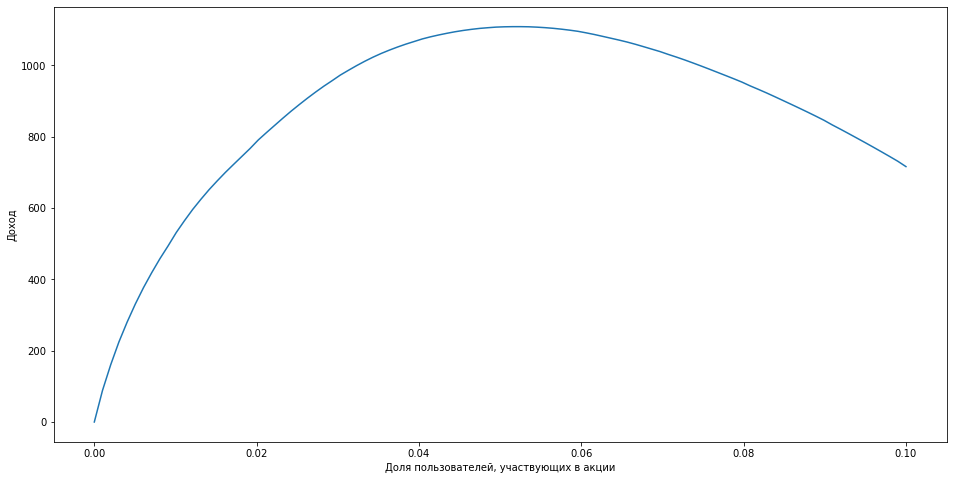

In [21]:
plt.figure(figsize=(16,8))
plt.xlabel('Доля пользователей, участвующих в акции')
plt.ylabel('Доход')
plt.plot(part_prop, incomes)
plt.show()

In [16]:
print(f'Максимальный доход достигается при доле пользователей = {part_prop[np.argmax(incomes)]:.3f}')
print(f'Максимальный доход = {np.amax(incomes):.1f}')

Максимальный доход достигается при доле пользователей = 0.022
Максимальный доход = 578.9


Теперь изменим вероятность принятия акции

In [17]:
accept_prob = 0.3

In [18]:
part_prop = np.linspace(0, 0.01, 100)
incomes = []
for p_p in part_prop:
    incomes.append(model(pred, part_prop=p_p, hold_cost=hold_cost, accept_prob=accept_prob))

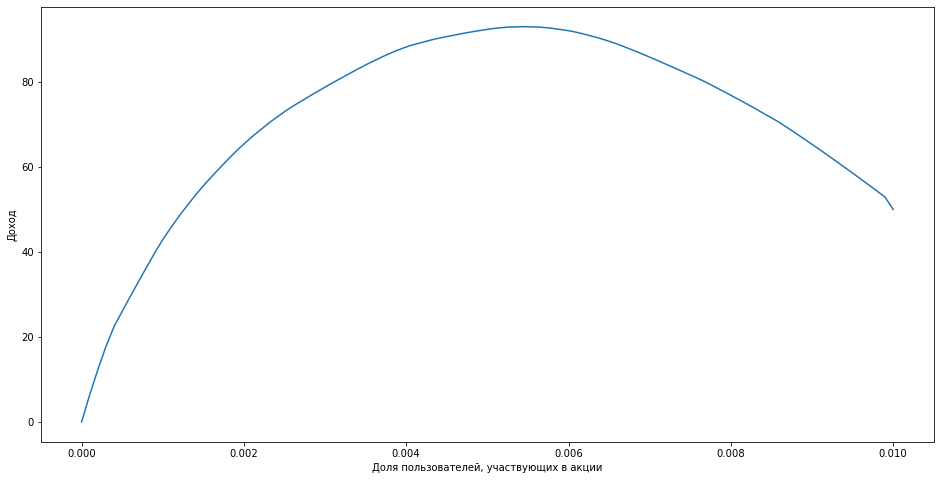

In [19]:
plt.figure(figsize=(16,8))
plt.xlabel('Доля пользователей, участвующих в акции')
plt.ylabel('Доход')
plt.plot(part_prop, incomes)
plt.show()

In [20]:
print(f'Максимальный доход достигается при доле пользователей = {part_prop[np.argmax(incomes)]:.3f}')
print(f'Максимальный доход = {np.amax(incomes):.1f}')

Максимальный доход достигается при доле пользователей = 0.005
Максимальный доход = 92.9


Как видим, уже при таком незначительном изменении условий, наша модель становится околонулевой. А оптимальный размер топа все сильнее уменьшается, оставляя только наиболее вероятных к оттоку пользователей.

Посмотрим как изменяется доход модели со стандартными параметрами и зафиксированным part_prop=0.09 при изменении цены удержания.

In [21]:
part_prop = 0.09
hold_cost = np.linspace(0, 4, 100)

In [22]:
incomes = []
for h_c in hold_cost:
    incomes.append(model(pred, part_prop=part_prop, hold_cost=h_c))

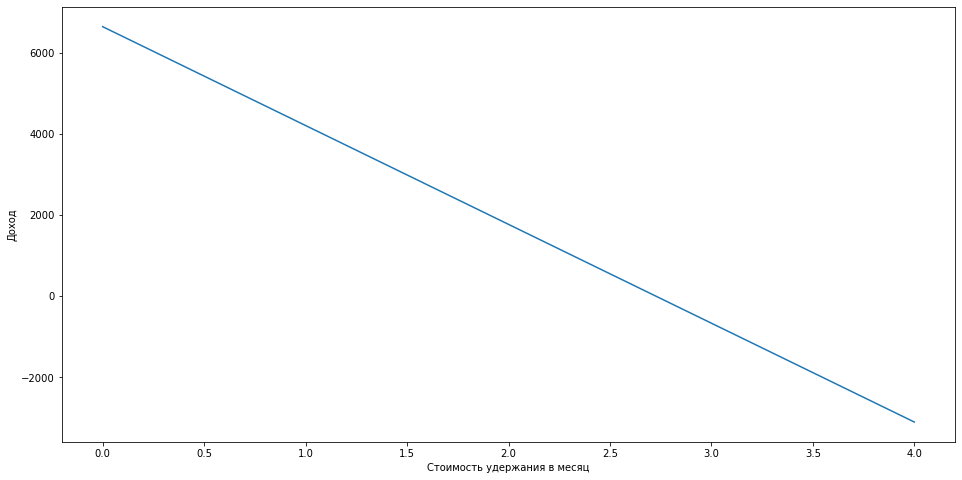

In [23]:
plt.figure(figsize=(16,8))
plt.xlabel('Стоимость удержания в месяц')
plt.ylabel('Доход')
plt.plot(hold_cost, incomes)
plt.show()

Модель становится нулевой при цене удержания примерно 2.8

Модель очень часто не оправдана, варианты видны из графиков - если стоимость удержания выше 2.8 на последнем. Слишком большая доля пользователей на предыдущих.

Сложно оценить повышение качества модели при увеличении точности на 1-3%, т.к. мы использовали ROC-AUC метрику. Для большего понимания ситуации, нужно изучать и работать над уменьшением количества ошибок первого/второго рода

Улучшение модели может привести к серьезному увеличению прибыли, т.к. мы отсеим больше "ложно-положительных пользователей", кому мы даём бонус, но которые не собирались уходить, это основные потери нашей модели. 